In [1]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
#Get Inception V3 model
INC=K.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [21]:
#Checking model information
INC.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [22]:
#Checking for mixed layers to extract activations from and rebuilding model with the outputs of those layers.
outputs = []
for x in INC.layers:
    if 'mixed' in x.name:
        print(x.name)
        outputs.append(x.output)
interINC=tf.keras.Model([INC.input], outputs)

mixed0
mixed1
mixed2
mixed3
mixed4
mixed5
mixed6
mixed7
mixed8
mixed9_0
mixed9
mixed9_1
mixed10


In [33]:
#Picture size
psize=200

#Loading picture
im=Image.open('./deepstyle/dalitime.jpg')
whiteim=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)[:,:,:,::-1]/255.0
img = tf.Variable(whiteim)
base_shape = tf.cast(tf.shape(img)[1:-1], tf.float32)

#Getting total image variance, can be used for smoothing later
origvar=tf.reduce_sum(tf.image.total_variation(img))

In [34]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#Describing loss as simple mean activation of the monitored layers
def contentloss(actlist):
    losses = []
    for act in actlist:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
    return  tf.reduce_sum(losses)
   

layerlist=[5] #List of output layer indices to check when dreaming
filterlist=np.arange(0,512).astype(np.int32) #Filters to use in the above mentioned layers
stepsize=0.01 #Stepsize of gradient descent

#Maximizing loss to get more active monitored layers
def contentopt(img,layerlist,filterlist,stepsize,origvar):
    with tf.GradientTape() as g:
        pred=interINC(img) #Getting activations
        loss=contentloss([pred[x][:,:,:,filter] for filter in filterlist for x in layerlist]) #Calculating loss
        
    gradients = g.gradient(loss,img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8 #Normalizing gradients
    img.assign(tf.clip_by_value(img+gradients*stepsize, 0, 1)) #Adding gradients*stepsize to maximaze loss instead of minimizing
    print(loss)
    return img
    
    
OCTAVE_SCALE = 1.1 #Factor of scaling when going for octaves


tf.Tensor(128.8204, shape=(), dtype=float32)
tf.Tensor(144.88573, shape=(), dtype=float32)
tf.Tensor(161.59445, shape=(), dtype=float32)
tf.Tensor(177.54175, shape=(), dtype=float32)
tf.Tensor(194.12077, shape=(), dtype=float32)
tf.Tensor(208.5903, shape=(), dtype=float32)
tf.Tensor(221.64761, shape=(), dtype=float32)
tf.Tensor(233.72006, shape=(), dtype=float32)
tf.Tensor(244.7055, shape=(), dtype=float32)
tf.Tensor(254.2207, shape=(), dtype=float32)
tf.Tensor(263.45227, shape=(), dtype=float32)
tf.Tensor(273.0031, shape=(), dtype=float32)
tf.Tensor(280.39594, shape=(), dtype=float32)
tf.Tensor(287.63916, shape=(), dtype=float32)
tf.Tensor(293.5346, shape=(), dtype=float32)
tf.Tensor(298.9563, shape=(), dtype=float32)
tf.Tensor(308.04956, shape=(), dtype=float32)
tf.Tensor(313.6416, shape=(), dtype=float32)
tf.Tensor(320.16452, shape=(), dtype=float32)
tf.Tensor(325.67715, shape=(), dtype=float32)
tf.Tensor(332.9166, shape=(), dtype=float32)
tf.Tensor(336.04224, shape=(), dtype=float3

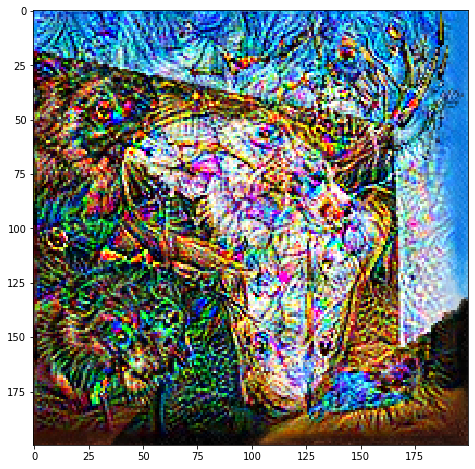

In [35]:

for n in np.arange(0,2): #Input scaling constants
    new_shape = tf.cast(base_shape*(OCTAVE_SCALE**n), tf.int32) #Scale image]
    img =tf.Variable(tf.image.resize(img, new_shape).numpy())
    for i in range(30):
        cucc=contentopt(img,layerlist,filterlist,stepsize,origvar) #Optimize for 1 step

#Plotting result
#imgplot=tf.image.resize(img, tf.cast(base_shape,tf.int32))
plt.figure(figsize=(8,8))
plt.imshow(imgplot.numpy().reshape(psize,psize,3)[:,:,::-1])
plt.show()
